# GroundingDINO + SAM + Inpaint Demo

In [ ]:
#! pip install -U torchmetrics==0.6.0

In [1]:
import numpy as np
from PIL import Image

import torch
import torchvision.transforms as T
import intel_extension_for_pytorch as ipex

import importlib
from omegaconf import OmegaConf
from ldm.models.diffusion.ddim import DDIMSampler

/home/wayne/.env/ov/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def instantiate_from_config(config):
    if not "target" in config:
        if config == '__is_first_stage__':
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

In [3]:
def load_image(image_path, size=[512,512]):
    image_pil = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = transform(image_pil)  # 3, h, w
    return image_pil, image

In [4]:
config = OmegaConf.load("config/v1-inpainting-inference.yaml")
inpaint = instantiate_from_config(config.model)

LatentInpaintDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.54 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from ../checkpoints/stablediffusion/sd-v1-5-inpainting.ckpt with 0 missing and 3 unexpected keys
Unexpected Keys: ['model_ema.decay', 'model_ema.num_updates', 'cond_stage_model.transformer.text_model.embeddings.position_ids']


In [12]:
inpaint.model.diffusion_model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(9, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(320, 320, kernel_size=(3, 

In [10]:
inpaint.first_stage_model

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

In [11]:
inpaint.cond_stage_model

FrozenCLIPEmbedder(
  (transformer): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=76

In [ ]:
device = torch.device('xpu')

_ = inpaint.eval()
inpaint.to(device)
inpaint = ipex.optimize(inpaint)

In [16]:
import openvino as ov
print(ov.__version__)

2023.1.0-12185-9e6b00e51cd-releases/2023/1


In [18]:
sampler = DDIMSampler(inpaint)

In [13]:
image_pil, image = load_image("assets/inpaint_demo.jpg")

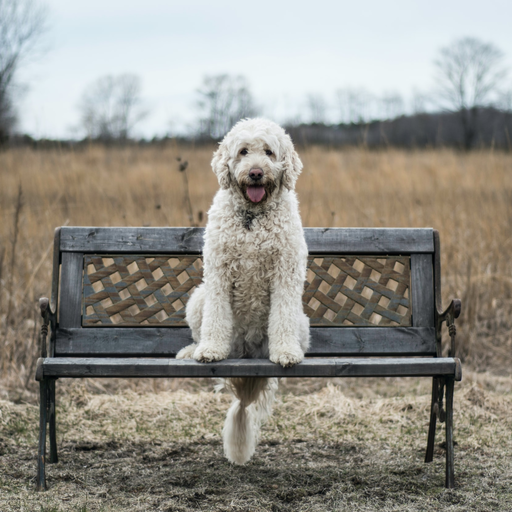

In [14]:
image_pil

In [15]:
catpion = "bench"

In [16]:
image = image[None].to(device)

In [17]:
from einops import repeat

def make_batch(image_pil, mask_pil, txt, device='xpu', num_samples=1):
    image = np.array(image_pil)
    image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image).to(dtype=torch.float32)/127.5-1.0

    mask = np.array(mask_pil)
    mask = mask.astype(np.float32)/255.0
    mask = mask[None,None]
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    masked_image = image * (mask < 0.5)

    batch = {
        "image": repeat(image.to(device=device), "1 ... -> n ...", n=num_samples),
        "txt": num_samples * [txt],
        "mask": repeat(mask.to(device=device), "1 ... -> n ...", n=num_samples),
        "masked_image": repeat(masked_image.to(device=device), "1 ... -> n ...", n=num_samples),
    }
    return batch

In [ ]:
mask = detections.mask[0]
mask_pil = Image.fromarray(mask)

image_pil = image_pil.resize((512, 512))
mask_pil = mask_pil.resize((512, 512))
inpaint_prompt = "sofa"
#inpaint_prompt = "A black cat"
num_samples=1
ddim_steps=1
scale=7.5
prng = np.random.RandomState(42)
start_code = prng.randn(num_samples, 4, h//8, w//8)
start_code = torch.from_numpy(start_code).to(device=device, dtype=torch.float32)

with torch.no_grad():
    batch = make_batch(image_pil, mask_pil, inpaint_prompt)
    c = inpaint.cond_stage_model.encode(batch["txt"])

    c_cat = list()
    for ck in inpaint.concat_keys:
        cc = batch[ck].float()
        if ck != inpaint.masked_image_key:
            bchw = [num_samples, 4, h//8, w//8]
            cc = torch.nn.functional.interpolate(cc, size=bchw[-2:])
        else:
            cc = inpaint.get_first_stage_encoding(inpaint.encode_first_stage(cc))
        c_cat.append(cc)
    c_cat = torch.cat(c_cat, dim=1)

    # cond
    cond={"c_concat": [c_cat], "c_crossattn": [c]}

    # uncond cond
    uc_cross = inpaint.get_unconditional_conditioning(num_samples, "")
    uc_full = {"c_concat": [c_cat], "c_crossattn": [uc_cross]}

    shape = [inpaint.channels, h//8, w//8]
    samples_cfg, intermediates = sampler.sample(
            ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=False,
            eta=1.0,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=uc_full,
            x_T=start_code,
    )
    x_samples_ddim = inpaint.decode_first_stage(samples_cfg)

    result = torch.clamp((x_samples_ddim+1.0)/2.0,
                         min=0.0, max=1.0)

    result = result.cpu().numpy().transpose(0,2,3,1)
    #result, has_nsfw_concept = check_safety(result)
    result = result*255

    result = [Image.fromarray(img.astype(np.uint8)) for img in result]
    #result = [put_watermark(img) for img in result]
    #return result

In [28]:
image_pil = Image.open('./assets/inpaint_demo.jpg')
image = np.array(image_pil.convert('RGB'))

In [29]:
image.shape

(512, 512, 3)

In [23]:
image = image[None].transpose(0,3,1,2)

In [24]:
image.shape

(1, 3, 512, 512)

In [25]:
image = torch.from_numpy(image).to(dtype=torch.float16)/127.5 - 1.0